# Тетрадка с визуализацией
## Начало проекта 

**Данные таблиц `Taxi Trips - 2022-2023`**

Набор данных о поездках на такси из города Чикаго за 2022-2023 год. Данные собраны с различных агрегаторов с целью проведения совокупного анализа, все пользователи обезличенны. Время округляется до ближайших 15 минут.

Описание содержания столбцов таблицы:
* `Trip ID` - уникальный идентификатор поездки;
* `Taxi ID` - уникальный идентификатор такси;
* `Trip Start Timestamp` - время начала поездки округляется до ближайших 15 минут;
* `Trip End Timestamp` - время завершения поездки, округляется до ближайших 15 минут;
* `Trip Seconds` - 	время поездки в секунда;.
* `Trip Mile` - расстояние поездки в милях;
* `Pickup Census Trac` - начало поездки;
* `Dropoff Census Trac` - завершение поездки;
* `Pickup Community Are` - общественная зона начала поездки;
* `Dropoff Community Are` - общественная зона завершения поездки;
* `Far` - cтоимость проезда;
* `Tip` - чаевые; 
* `Toll` - налог;
* `Extra` - дополнительные расходы на поездку;
* `Trip Tota` - общая стоимость поездки;
* `Payment Typ` - способ оплаты;
* `Compan` - компания такси;
* `Pickup Centroid Latitud` - широта (за пределами Чикаго запись отсутствует);
* `Pickup Centroid Longitud` - долгота (за пределами Чикаго запись отсутствует);
* `Pickup Centroid Locatio` - местоположение общественной территории; 
* `Dropoff Centroid Latitud` - широта местоположение общественной территории;
* `Dropoff Centroid Longitud` -долгота местоположение общественной территорииe;
* `Dropoff Centroid Locatio` - высодка местоположени;

Данные представлены в двух таблицах, за один год и половину года. Таблицы друг с другом соединятся с сохранением временной последовательность. 

## Все библиотеки, которые были задействованы в обучении 

In [1]:
!pip install pyspark

In [2]:
import os 
import pandas as pd
import numpy as np

import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#visual
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 480)

from matplotlib import rcParams 
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
#format
from pyspark.sql.functions import (to_timestamp, date_trunc, month, 
                                   year, dayofweek, avg, hour, 
                                   dayofmonth, lag, expr,
                                   sin, cos)

from pyspark.sql.window import Window

In [6]:
rnd_seed=23
np.random.seed=rnd_seed 
np.random.set_state=rnd_seed

## Созданеиее sparkSession

In [7]:
#SPARK_MASTER_IP = '172.18.0.2'

#spark = SparkSession.builder.appName("pyspark-taxi-forecasting") \
#    .master(f"spark://{SPARK_MASTER_IP}:7077") \
#    .config("spark.executor.cores", 1) \
#    .config("spark.task.cpus", 1) \
#    .getOrCreate()

spark = SparkSession.builder.appName("pyspark-taxi-forecasting") \
        .config("spark.executor.cores", 1) \
        .config("spark.task.cpus", 1) \
        .master("local[*]") \
        .config('spark.driver.bindAddress','localhost') \
        .config('spark.ui.port', 4040) \
        .getOrCreate()

In [8]:
spark.getActiveSession()

## Функции, которые были написаны для обработки df

In [9]:
#функция
#группируем по 1 часу и районам
def tables_area(df):
    df.createOrReplaceTempView("table")

    tables_dict = {}
    
    for i in range(1, 78):
        name = i
        tab = spark.sql(f"""
            select datetime, 
                   sum(count_1h) as count_1h
            from (select
                        date_format(datetime, "yyyy-MM-dd HH:00:00") as datetime,
                        count(*) as count_1h
                              from (select id, datetime from table where area = {i}) as ar
                    GROUP BY datetime
                    ORDER BY datetime) as t
            GROUP BY datetime
            ORDER BY datetime
                        """)
        # Сохраняем таблицу в словаре с использованием имени как ключа
        tables_dict[name] = tab
    
    return tables_dict  # Возвращаем словарь с таблицами

# Запуск данных и обработка
Старался максимально группировать код чтобы spark выполнял быстрее запросы и не забивал оперативную память. По той же причине старался как можно меньше конечных расчетов с выводом на экран. В данной тете представлены вся основная информация и визуализация о данных. 

In [10]:
taxi_22 = "fails/Taxi_Trips_-_2022.csv"
taxi_23 = "fails/Taxi_Trips_-_2023.csv"

sdf_22 = spark.read.csv(path=taxi_22, header=True, inferSchema=True)
#выбор столбцов
sdf_22 = sdf_22.select(["Trip ID", "Trip Start Timestamp", 'Pickup Community Area'])

sdf_23 = spark.read.csv(path=taxi_23, header=True, inferSchema=True)

#выборка только основных столбцов
sdf_23 = sdf_23.select(['Trip ID', 'Trip Start Timestamp', 'Pickup Community Area'])
#Переименовал столбцы 
sdf = sdf_22.union(sdf_23)
sdf = sdf.withColumnRenamed("Trip Start Timestamp", "datetime")
sdf = sdf.withColumnRenamed("Pickup Community Area", "area")
sdf = sdf.withColumnRenamed("Trip ID", "id")

#изменение формата в столбце с датой и временем начала поездки  
timestamp_format = "MM/dd/yyyy hh:mm:ss a"
sdf = sdf.withColumn("datetime", to_timestamp("datetime", timestamp_format))

#удаление пропусков
sdf = sdf.na.drop()
sdf.cache()

#группировка по 1 часу
table_areas = tables_area(sdf)

#min seria
time = sdf.select('datetime').groupby(date_trunc('hour', 'datetime')).count()\
       .withColumnRenamed("date_trunc(hour, datetime)", "datetime")\
       .orderBy('datetime')\
       .select('datetime')
#заполнение недостающих часов 0
for i in range(1, 78):
    table_areas[i] = table_areas[i]\
                     .join(time, on='datetime', how='right_outer')\
                     .orderBy('datetime')\
                     .fillna(0)
    table_areas[i].cache()

DataFrame[id: string, datetime: timestamp, area: int]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

DataFrame[datetime: timestamp, count_1h: bigint]

# Анализ данных

In [11]:
lines = sdf_22.count()
print("Количество строк в DataFrame taxi_22:", lines)

Количество строк в DataFrame taxi_22: 6382425


In [12]:
lines = sdf_23.count()
print("Количество строк в DataFrame taxi_23:", lines)

Количество строк в DataFrame taxi_23: 3783730


**Проверка наличия пропусков:**

In [13]:
# Подсчитываем количество пропусков
count_nulls = sdf.select("area").filter(col("area").isNull()).count()
print('Количество пропусков в столбце area:', count_nulls)

Количество пропусков в столбце area: 0


В первом запросе были удалены пропуски, т.к. согласно документации если не указан район, значит был заказ из пригорода, а нас интересует центр города. Данная проверка контрольная.

## Группировка по 15 мин

In [14]:
#группировока по 15 мин
sdf_15 = sdf.groupby('datetime').count()
sdf_15 = sdf_15.withColumnRenamed("count", "count_15")
sdf_15 = sdf_15.orderBy('datetime')

In [15]:
#сортировку по столбцу Trip Start Timestamp 
sdf_15 = sdf_15.orderBy(sdf_15['datetime'])

In [16]:
lines_group = sdf_15.count()
print("Количество строк taxi после группировки:", lines_group)

Количество строк taxi после группировки: 55385


In [17]:
#группируем по часам
sdf.createOrReplaceTempView("table")
sdf_1h = spark.sql("""
    SELECT datetime, 
           sum(count_1h) as count_1h
    FROM (SELECT
                date_format(datetime, "yyyy-MM-dd HH:00:00") as datetime,
                count(*) as count_1h
          FROM
                  table
          GROUP BY
                  datetime
          ORDER BY
                  datetime) as t
    GROUP BY datetime
    ORDER BY datetime
""")

In [18]:
lines_group = sdf.count()
print("Количество строк taxi после группировки:", lines_group)

Количество строк taxi после группировки: 9484535


In [19]:
#добавить сортировку по столбцу Trip Start Timestamp 
sdf_15 = sdf_15.orderBy(sdf_15['datetime'])

In [20]:
#кол-во районов
sdf.select("area").distinct().count()

77

# Визуализация 

## Изучение таблицы с заказами за 15 минут

In [21]:
#общий анализ данных количества поездок в течение 15 мин
sdf_15.describe().show()

+-------+------------------+
|summary|          count_15|
+-------+------------------+
|  count|             55385|
|   mean|171.24735939333755|
| stddev|110.42454473740034|
|    min|                 1|
|    max|               501|
+-------+------------------+



In [22]:
# Определите размер окна для скользящей средней
window_size = 50

# Определите окно
window = Window.orderBy("datetime").rowsBetween(-(window_size - 1), 0)

# Вычислите скользящую среднюю
sdf_15_roll = sdf_15.withColumn("Rolling", avg(col("count_15")).over(window))

# результат
#sdf_15_roll.show(30)

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


Text(0.5, 1.0, 'Количество заказов за 15 мин в течение года')

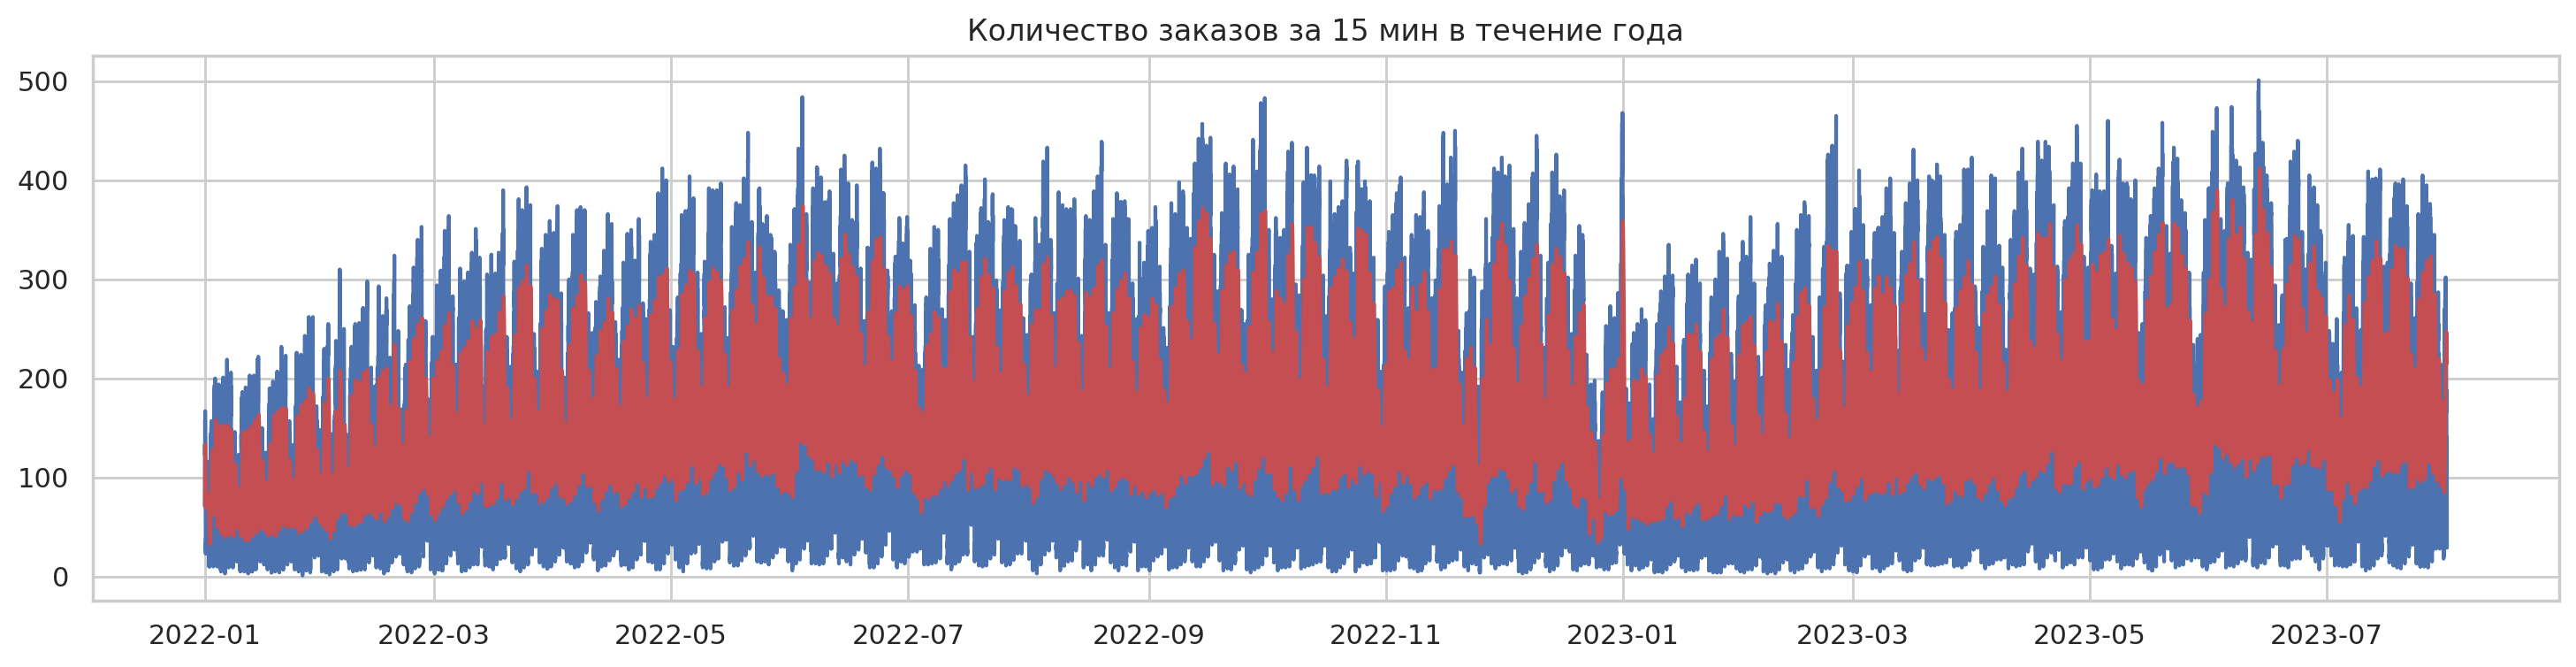

In [23]:
#DataFrame в Pandas DataFrame => таблицу 
pand_df = sdf_15_roll.toPandas()

plt.title("Количество заказов за 15 мин в течение года")
plt.plot(pand_df['datetime'], pand_df['count_15'])
plt.plot(pand_df['datetime'], pand_df['Rolling'], label=f"Скользящая средняя ({window_size}-дневная)", linestyle='-', color='r')

Спорный график, но для понимания как выглядят все данные и как будет выглядеть скользящая средняя на всем промежутке стоит взглянуть. Рассмотрим 1 месяц (март)

In [24]:
sdf_15_roll.createOrReplaceTempView("orders")

time_03 = spark.sql('''
            select datetime, count_15
            from orders
            where datetime > '2022-03-01' 
                  and datetime < '2022-04-01'
            ''')

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


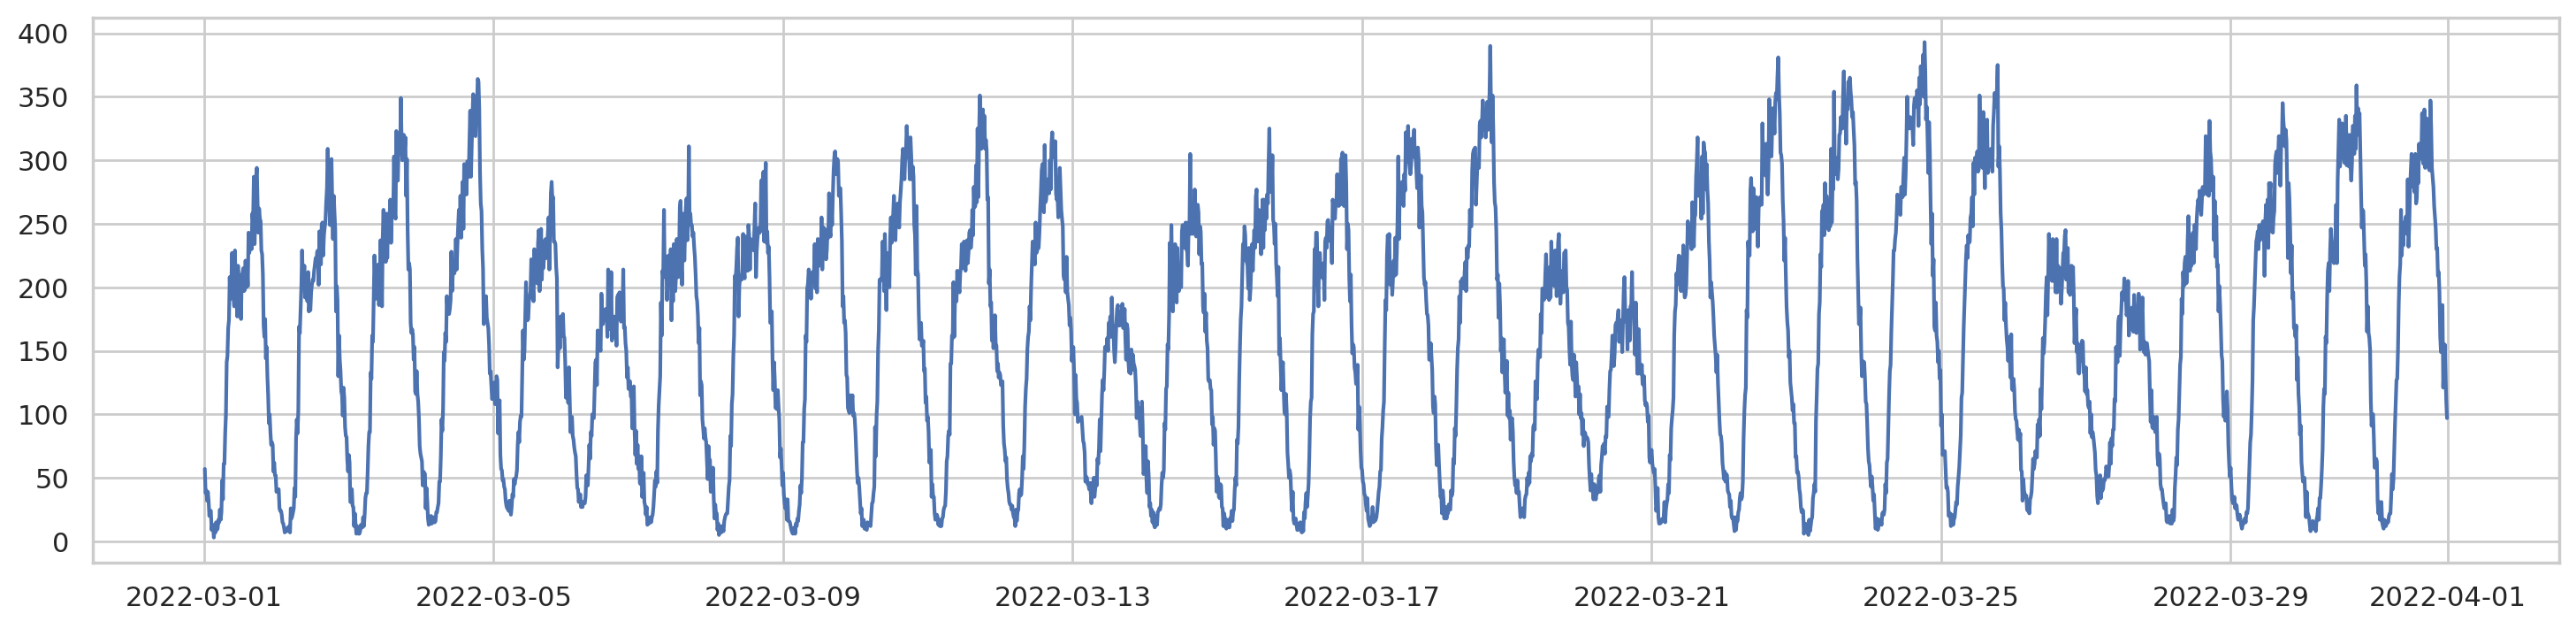

In [25]:
time_03 = time_03.toPandas()
plt.plot(time_03['datetime'], time_03['count_15'])

**Вывод:** при рассмотрении месячного среза, выявлена тенденция, что в будние дни спрос выше чем в выходные. Следовательно, целесообразно создать столбец, который будет содержать день недели (1-7). 

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


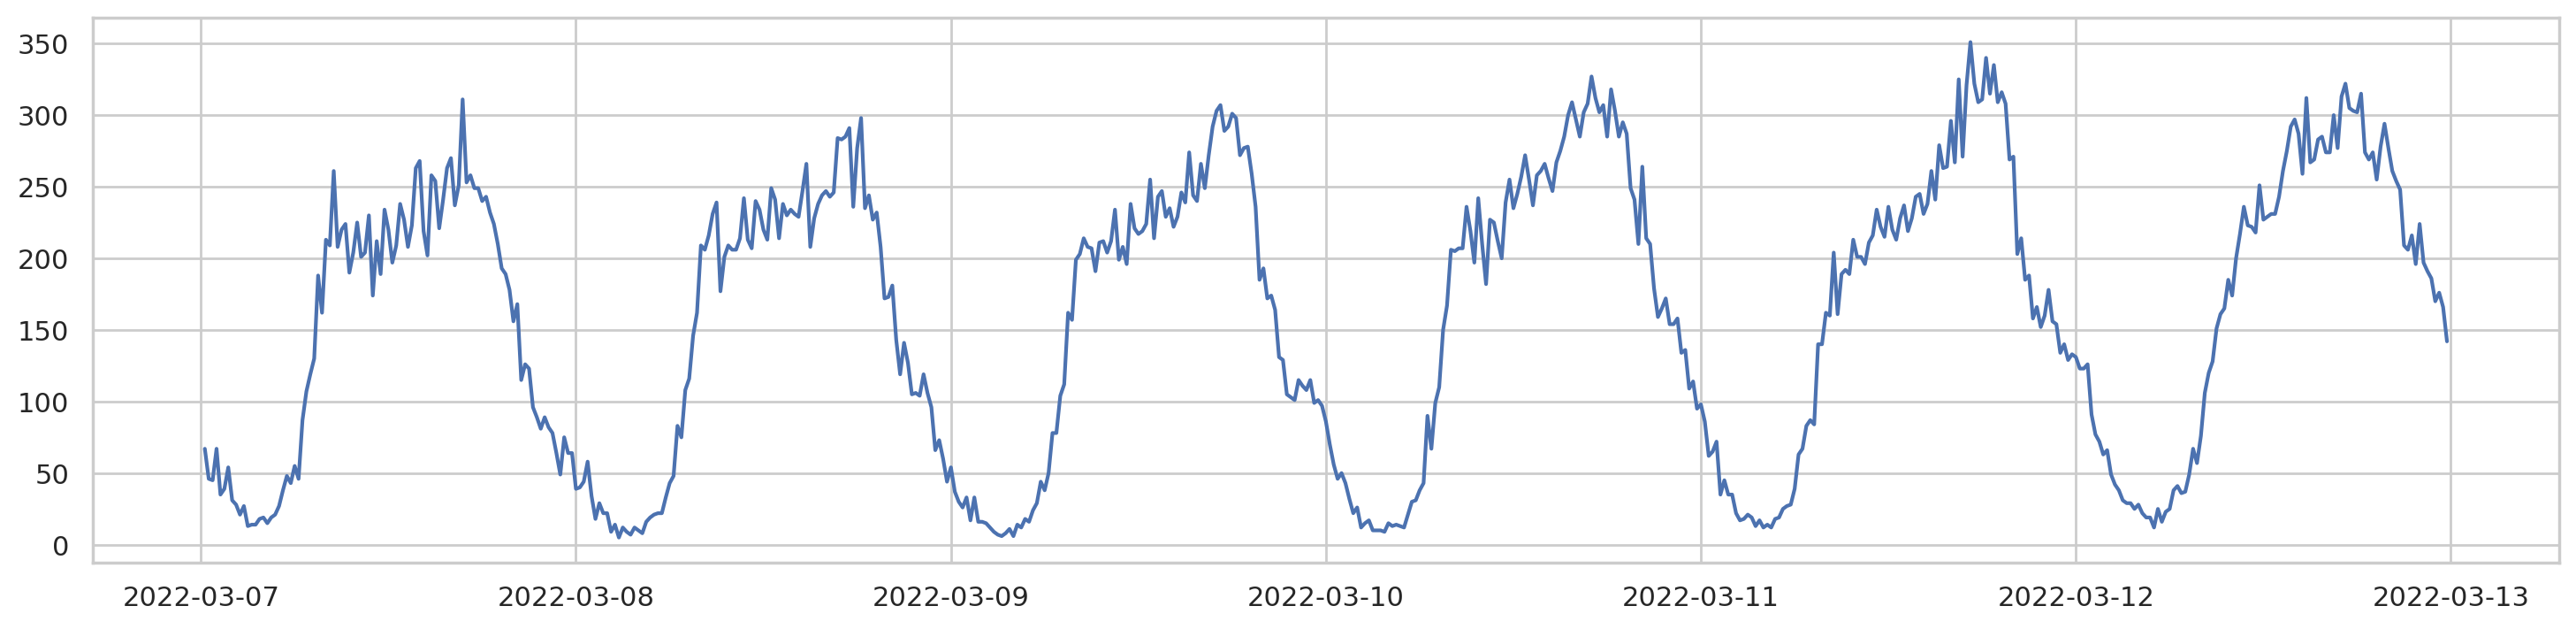

In [26]:
#спрос в течение 1 недели
sdf_15_roll.createOrReplaceTempView("orders")

time_03 = spark.sql('''
            select datetime, count_15
            from orders
            where datetime > '2022-03-07' 
                  and datetime < '2022-03-13'
            ''')
time_03 = time_03.toPandas()

plt.plot(time_03['datetime'], time_03['count_15'])

**Вывод:** недельный график отображает колебания недельного спроса всех заказов. Из графика видно, что в течение всей недели выражена суточная сезонность спроса, что весьма логично. Ночью спрос ниже, а к середине дня достигает своего пика. 

## Визуализация таблицы поездок за 1 час по каждому району 


In [27]:
table_areas[22].describe().show()

+-------+------------------+
|summary|          count_1h|
+-------+------------------+
|  count|             13847|
|   mean| 3.501119376038131|
| stddev|2.8062492509431762|
|    min|                 0|
|    max|                23|
+-------+------------------+



/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


Text(0.5, 1.0, 'Количество заказов случайных районов, в течение 1 месяца')

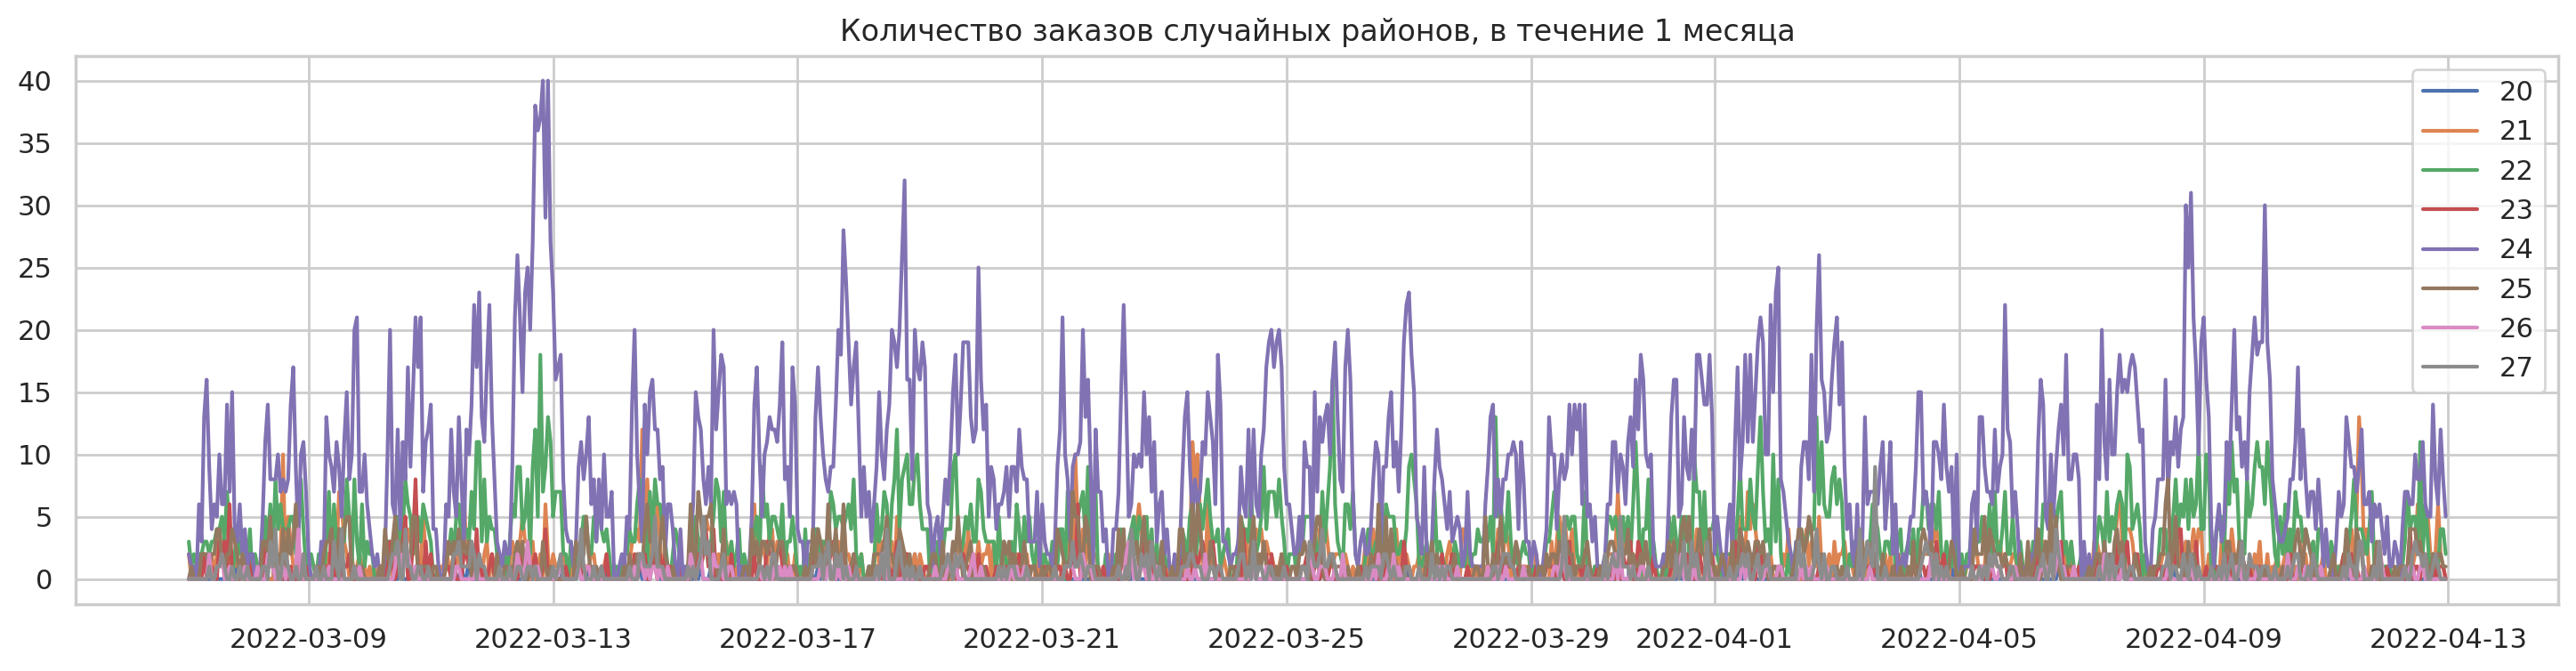

In [28]:
#спрос в течение месяца
for i in range(20, 28):
    table_areas[i].createOrReplaceTempView("orders")

    time_03 = spark.sql('''
            select datetime, count_1h
            from orders
            where datetime > '2022-03-07' 
                  and datetime < '2022-04-13'
            ''')
    time_03 = time_03.toPandas()

    # Явно привести столбец datetime к типу datetime64[ns]
    time_03['datetime'] = time_03['datetime'].astype('datetime64[ns]')
    
    plt.plot(time_03['datetime'], time_03['count_1h'], label=i)
plt.legend()
plt.title("Количество заказов случайных районов, в течение 1 месяца")

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


Text(0.5, 1.0, 'Количество заказов случайных районов, в течение 1 недели')

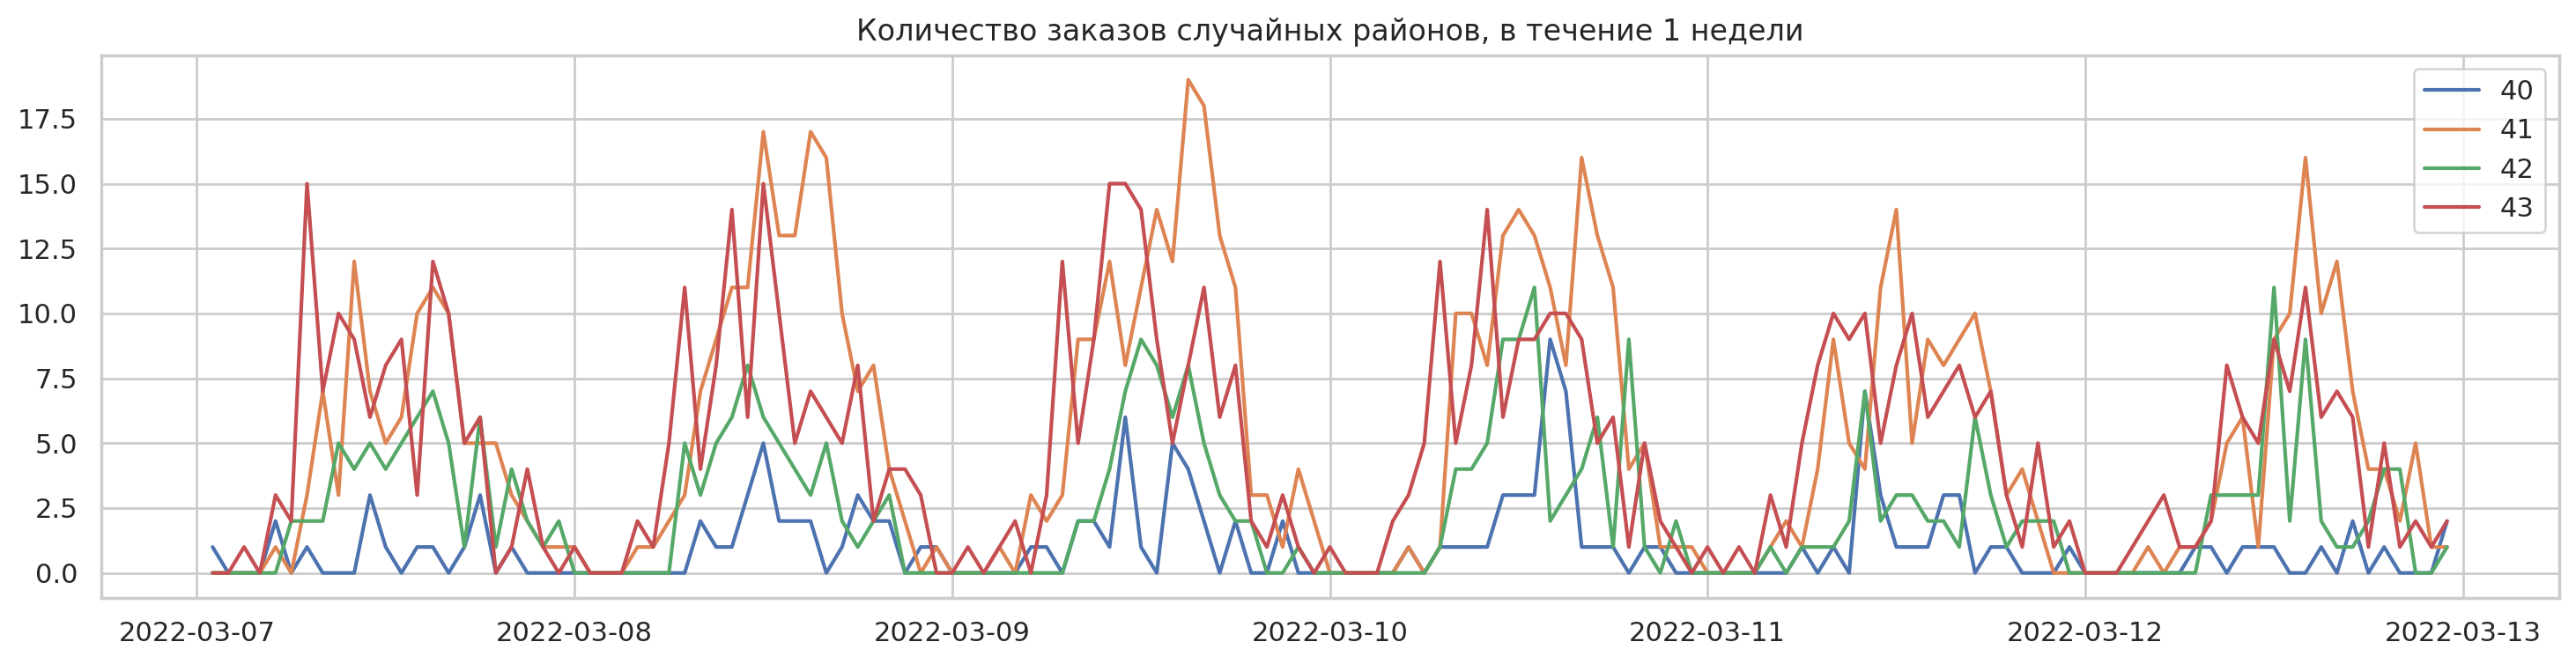

In [29]:
#спрос в течение недели
for i in range(40, 44):
    table_areas[i].createOrReplaceTempView("orders")

    time_03 = spark.sql('''
            select datetime, count_1h
            from orders
            where datetime > '2022-03-07' 
                  and datetime < '2022-03-13'
            ''')
    time_03 = time_03.toPandas()

    # Явно привести столбец datetime к типу datetime64[ns]
    time_03['datetime'] = time_03['datetime'].astype('datetime64[ns]')
    
    plt.plot(time_03['datetime'], time_03['count_1h'], label=i)
plt.legend()
plt.title("Количество заказов случайных районов, в течение 1 недели")

**Вывод:** в данных видно, ярко выраженную дневную сезонность заказов. В течение дня заказов значительно больше нежели чем вечером или раннем утром. Даже районы с небольшим спросом отражают данную сезонность. Так же есть районы, которые содержат очень небольшое количество заказов в течение дня, в дальнейшем целесообразно разделить их на группы и под них создать отдельно обученную модель.

In [30]:
spark.stop()